##Disclaimer

The algorithms and strategies presented in this tutorial are for educational purposes only and are not intended to provide financial or trading advice. The performance of the models and strategies demonstrated herein is based on historical data and may not accurately predict future market behavior. Trading financial markets involves substantial risk and may not be suitable for all investors. You should consult with a qualified financial advisor before making any investment decisions. The authors and publishers of this tutorial are not responsible for any losses incurred as a result of using the information contained within.

##Load modules and data

In [ ]:
# Import necessary modules
import numpy as np
import pandas as pd
import yfinance as yf
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [ ]:
# Define the stock symbol and the date range
stock_symbol = 'GOOGL'
start_date = '2015-01-01'
end_date = '2022-12-31'

In [ ]:
# Fetch the data
data = yf.download(stock_symbol, start=start_date, end=end_date)

# Display the first few rows of the dataset
print(data.head())

[*********************100%%**********************]  1 of 1 completed

                 Open       High        Low      Close  Adj Close    Volume
Date                                                                       
2015-01-02  26.629999  26.790001  26.393999  26.477501  26.477501  26480000
2015-01-05  26.357500  26.399500  25.887501  25.973000  25.973000  41182000
2015-01-06  26.025000  26.060499  25.277500  25.332001  25.332001  54456000
2015-01-07  25.547501  25.574499  25.182501  25.257500  25.257500  46918000
2015-01-08  25.075500  25.375000  24.750999  25.345501  25.345501  73054000


##Clean data

In [ ]:
# Select features and target
features = data[['Open', 'High', 'Low', 'Close', 'Volume']]
target = data['Close']

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler.fit_transform(features)

## Develop and train model

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(scaled_features, target, test_size=0.2, random_state=42)

# Reshape data for LSTM [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [ ]:
# Build the model
model = Sequential()

# Add LSTM layer
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))

# Add another LSTM layer
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))

# Add a dense layer
model.add(Dense(units=25))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Model summary
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 1, 50)             11200     
                                                                 
 dropout_4 (Dropout)         (None, 1, 50)             0         
                                                                 
 lstm_5 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_5 (Dropout)         (None, 50)                0         
                                                                 
 dense_4 (Dense)             (None, 25)                1275      
                                                                 
 dense_5 (Dense)             (None, 1)                 26        
                                                                 
Total params: 32701 (127.74 KB)
Trainable params: 3270

In [ ]:
# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test), verbose=1)

Epoch 1/10
51/51 [==============================] - 9s 91ms/step - loss: 5688.3003 - val_loss: 5229.7158
Epoch 2/10
51/51 [==============================] - 0s 5ms/step - loss: 3988.0271 - val_loss: 1811.0092
Epoch 3/10
51/51 [==============================] - 0s 5ms/step - loss: 754.5714 - val_loss: 270.4858
Epoch 4/10
51/51 [==============================] - 0s 6ms/step - loss: 266.1556 - val_loss: 152.6329
Epoch 5/10
51/51 [==============================] - 0s 6ms/step - loss: 160.4635 - val_loss: 83.5125
Epoch 6/10
51/51 [==============================] - 0s 5ms/step - loss: 116.0790 - val_loss: 49.8412
Epoch 7/10
51/51 [==============================] - 0s 6ms/step - loss: 87.3916 - val_loss: 37.1436
Epoch 8/10
51/51 [==============================] - 0s 5ms/step - loss: 70.4845 - val_loss: 30.9993
Epoch 9/10
51/51 [==============================] - 0s 5ms/step - loss: 72.5287 - val_loss: 25.3821
Epoch 10/10
51/51 [==============================] - 0s 5ms/step - loss: 63.5142 - va

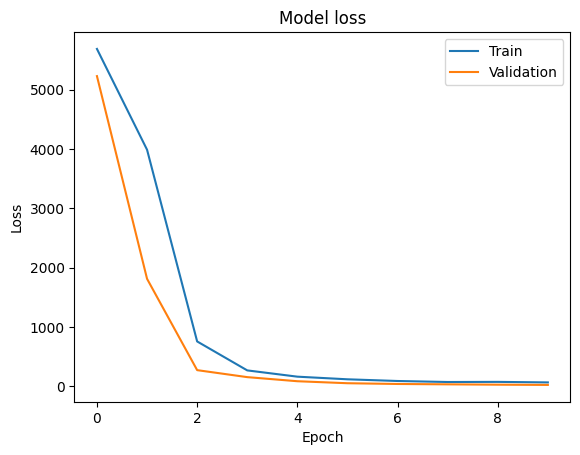

In [ ]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

##Evaluate model

13/13 [==============================] - 1s 2ms/step


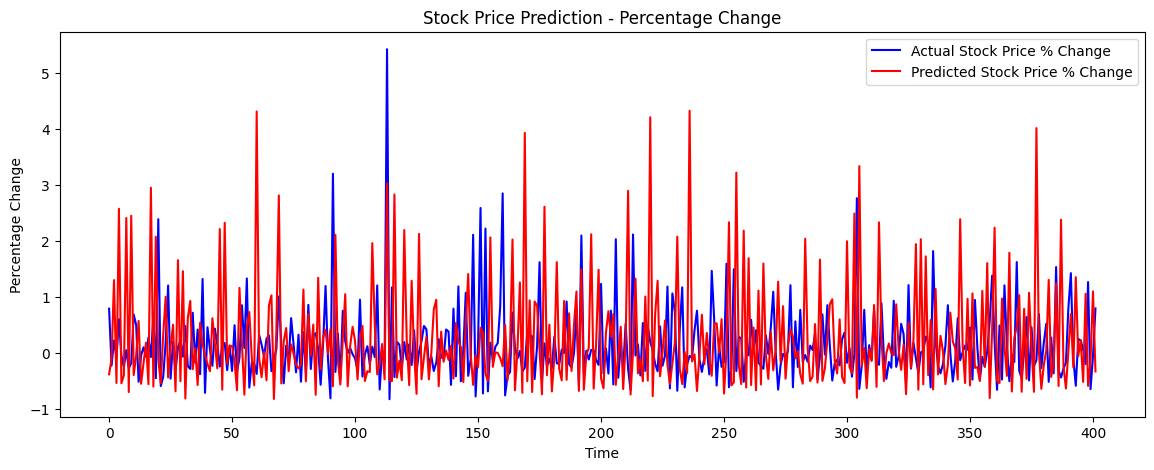

In [ ]:
# Make predictions for the test dataset
predictions = model.predict(X_test)

# Inverse scaling for the predictions
scaled_X_test = X_test.reshape(X_test.shape[0], X_test.shape[2])
predictions_combined = np.concatenate((scaled_X_test[:, :-1], predictions), axis=1)
predictions = scaler.inverse_transform(predictions_combined)[:, -1]

# Inverse scaling for the actual values
actual = scaler.inverse_transform(scaled_X_test)[:, -1]

# Calculate percentage change
predictions_pct_change = pd.Series(predictions).pct_change().dropna()
actual_pct_change = pd.Series(actual).pct_change().dropna()

# Align the lengths of actual and predicted percentage changes
min_length = min(len(predictions_pct_change), len(actual_pct_change))
predictions_pct_change = predictions_pct_change.iloc[:min_length]
actual_pct_change = actual_pct_change.iloc[:min_length]

# Plot the results
plt.figure(figsize=(14, 5))
plt.plot(actual_pct_change.values, color='blue', label='Actual Stock Price % Change')
plt.plot(predictions_pct_change.values, color='red', label='Predicted Stock Price % Change')
plt.title('Stock Price Prediction - Percentage Change')
plt.xlabel('Time')
plt.ylabel('Percentage Change')
plt.legend()
plt.show()

In [ ]:
# Evaluate the model
mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)

print(f'Mean Absolute Error: {mae}')
print(f'Mean Squared Error: {mse}')

Mean Absolute Error: 16704907671.869732
Mean Squared Error: 3.454117706725112e+20


##Integrating our model into a trading strategy


In [ ]:
# Define trading strategy
def trading_strategy(data):
  """A simple momentum-based strategy that uses the predicted closing prices to generate trading signals.
  Signals: 1 for buy, -1 for sell, based on the comparison of predicted and actual closing prices.
  Positions: Shifted signals to indicate the position for each day based on the previous day's signal.
  """
  data['Signal'] = 0
  data['Signal'][1:] = np.where(data['Predicted_Close'][1:].values > data['Actual_Close'][:-1].values, 1, -1)
  data['Position'] = data['Signal'].shift()


In [ ]:
# Prepare the data for making predictions
scaled_features = scaler.transform(features)
X_all = np.reshape(scaled_features, (scaled_features.shape[0], 1, scaled_features.shape[1]))

# Make predictions for the entire dataset
all_predictions = model.predict(X_all)

# Add predictions to the original data
data['Predicted_Close'] = scaler.inverse_transform(
    np.concatenate([scaled_features[:, :-1], all_predictions], axis=1)
)[:, -1]
data['Actual_Close'] = target.values  # Actual close prices

trading_strategy(data)

# Calculate daily returns
data['Market_Return'] = data['Actual_Close'].pct_change()

# Calculate strategy returns
data['Strategy_Return'] = data['Market_Return'] * data['Position']

# Calculate cumulative returns
data['Cumulative_Market_Return'] = (1 + data['Market_Return']).cumprod() - 1
data['Cumulative_Strategy_Return'] = (1 + data['Strategy_Return']).cumprod() - 1

# Display the first few rows with the new columns
data.head()

63/63 [==============================] - 0s 2ms/step


<ipython-input-60-b50cf25d638a>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Signal'][1:] = np.where(data['Predicted_Close'][1:].values > data['Actual_Close'][:-1].values, 1, -1)


,Open,High,Low,Close,Adj Close,Volume,Predicted_Close,Actual_Close,Signal,Position,Market_Return,Strategy_Return,Cumulative_Market_Return,Cumulative_Strategy_Return
Date,,,,,,,,,,,,,,
2015-01-02,26.629999,26.790001,26.393999,26.477501,26.477501,26480000,5.754306e+09,26.477501,0,NaN,NaN,NaN,NaN,NaN
2015-01-05,26.357500,26.399500,25.887501,25.973000,25.973000,41182000,5.784516e+09,25.973000,1,0.0,-0.019054,-0.000000,-0.019054,0.000000
2015-01-06,26.025000,26.060499,25.277500,25.332001,25.332001,54456000,5.788966e+09,25.332001,1,1.0,-0.024679,-0.024679,-0.043263,-0.024679
2015-01-07,25.547501,25.574499,25.182501,25.257500,25.257500,46918000,5.664687e+09,25.257500,1,1.0,-0.002941,-0.002941,-0.046077,-0.027548
2015-01-08,25.075500,25.375000,24.750999,25.345501,25.345501,73054000,5.829201e+09,25.345501,1,1.0,0.003484,0.003484,-0.042753,-0.024160


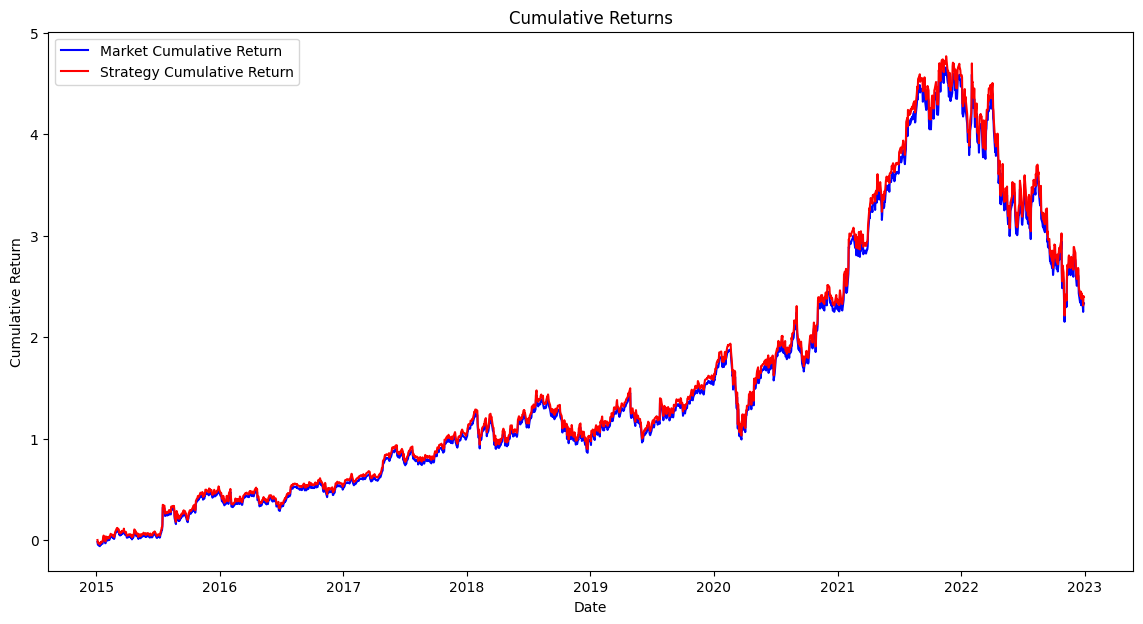

In [ ]:
# Plot cumulative returns
plt.figure(figsize=(14, 7))
plt.plot(data['Cumulative_Market_Return'], label='Market Cumulative Return', color='blue')
plt.plot(data['Cumulative_Strategy_Return'], label='Strategy Cumulative Return', color='red')
plt.title('Cumulative Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.show()


In [ ]:
# Calculate total returns
total_market_return = data['Cumulative_Market_Return'].iloc[-1]
total_strategy_return = data['Cumulative_Strategy_Return'].iloc[-1]

# Calculate Sharpe ratio
# Assuming a risk-free rate of 0 for simplicity
sharpe_ratio = data['Strategy_Return'].mean() / data['Strategy_Return'].std() * np.sqrt(252)  # Annualized Sharpe ratio

print(f'Total Market Return: {total_market_return * 100:.2f}%')
print(f'Total Strategy Return: {total_strategy_return * 100:.2f}%')
print(f'Sharpe Ratio: {sharpe_ratio:.2f}')

Total Market Return: 233.23%
Total Strategy Return: 239.70%
Sharpe Ratio: 0.68
